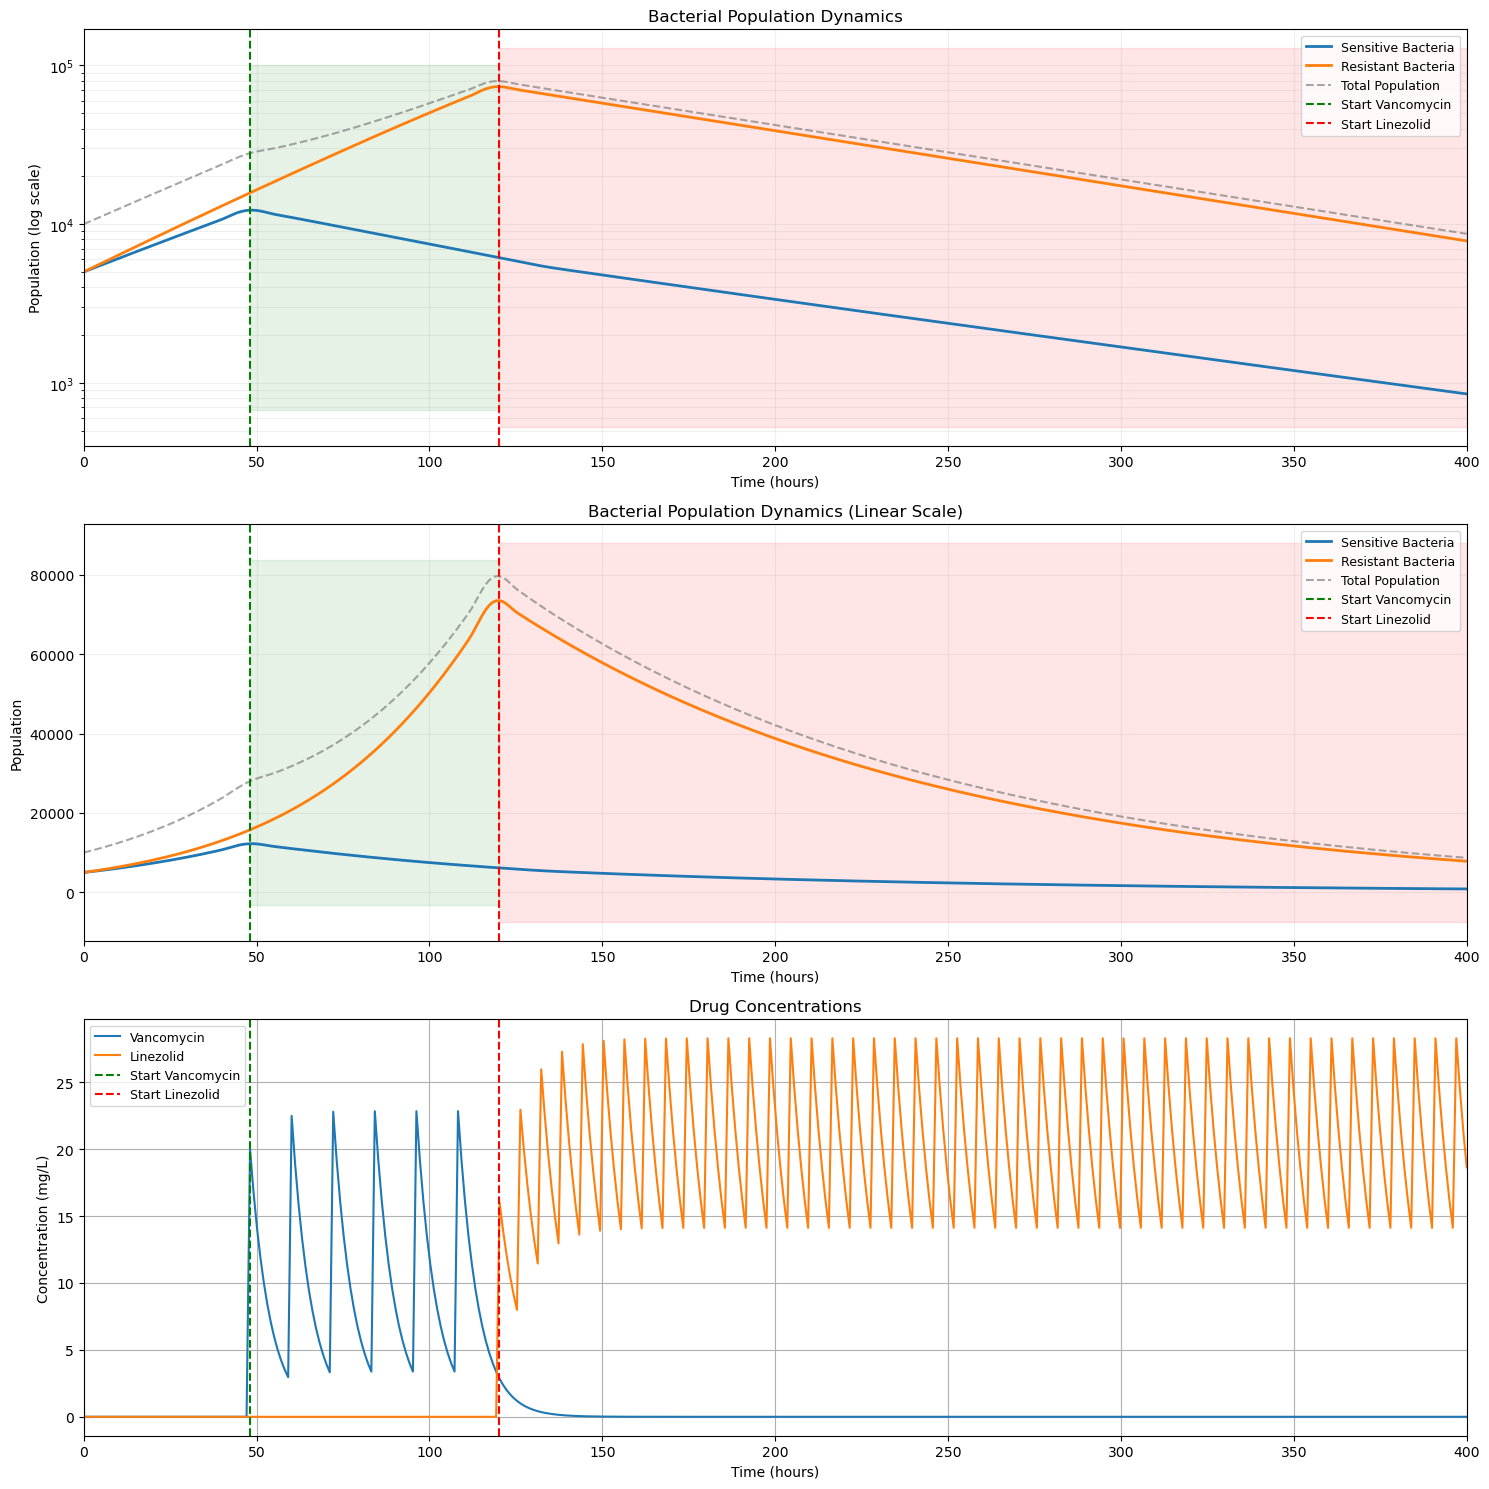


Model Summary:
--------------
Vancomycin: 1000mg every 12h for 72h (start: 48h)
Linezolid: 800mg every 6h continued to end of simulation (start: 120h)

Half-lives:
Vancomycin: 4 hours
Linezolid: 5 hours

Population Parameters:
Sensitive bacteria growth rate: 0.03
Resistant bacteria growth rate: 0.033
Sensitive bacteria death rate: 0.01
Resistant bacteria death rate: 0.008
Carrying capacity: 500000.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp



def combined_pk_pd_model(
    EC_50_vanco,
    EC_50_linez,
    initial_sensitive=5000,  # Increased population size
    initial_resistant=5000,   # Equal starting populations
    no_drug_period=48,
    total_time=400  # Extended from 216h to 400h to observe longer dynamics after treatment
):
    # Drug parameters
    vanco_dose = 1000  # mg
    linez_dose = 800  # mg
    volume = 50  # L
    vanco_half_life = 4  # hours(normal kidney: 4 - 6 hours)
    linez_half_life = 5  # hours(normal kidney: 5 - 7 hours)
    
    # Calculate elimination rates
    ke_vanco = np.log(2) / vanco_half_life
    ke_linez = np.log(2) / linez_half_life
    
    # Create time points for simulation
    t = np.linspace(0, total_time, total_time)
    
    # Initialize concentration arrays
    vanco = np.zeros_like(t, dtype=float)
    linez = np.zeros_like(t, dtype=float)
    
    # Add doses and calculate concentrations
    # Vancomycin: 500mg q12h for 72h starting at 48h
    vanco_conc = vanco_dose / volume
    for dose_time in range(no_drug_period, no_drug_period+72, 12):
        idx = dose_time
        vanco[idx:] += vanco_conc * np.exp(-ke_vanco * (t[idx:] - t[idx]))
    
    # Linezolid: 800mg q6h continuing until the end of simulation
    linez_conc = linez_dose / volume
    for dose_time in range(no_drug_period+72, total_time, 6):
        idx = dose_time
        if idx < len(linez):  # Make sure we don't go beyond array bounds
            linez[idx:] += linez_conc * np.exp(-ke_linez * (t[idx:] - t[idx]))
    
    # Population dynamics parameters
    rho_sensitive = 0.03  # Base growth rate for sensitive bacteria
    rho_resistant = 0.033  # Increased to show resistant bacteria with higher growth rate (10% higher than sensitive)
    delta_sensitive = 0.01  # Death rate for sensitive bacteria
    delta_resistant = 0.008  # Lower death rate for resistant bacteria 
    max_drug_effect_vanco = 0.99  # Increased from 0.95 for stronger vancomycin effect on sensitive
    max_drug_effect_linez = 0.99  # Increased to 0.99 for maximum linezolid effect
    k = 5e5  # Increased carrying capacity to allow more growth before saturation
    
    # EC50 values for resistant strain
    EC_50_vanco_sensitive = EC_50_vanco * 0.4  # Reduced from 0.5 - sensitive bacteria even more susceptible to vancomycin
    EC_50_linez_both = EC_50_linez * 0.4  # For sensitive bacteria
    
    def population_ode(t, y):
        S, R = y
        
        # Get drug effects at current time
        if t <= no_drug_period:
            total_inhibition_sensitive = 0
            total_inhibition_resistant = 0
        else:
            # Get current drug concentrations
            t_idx = int(t)
            if t_idx >= len(vanco):
                t_idx = len(vanco) - 1
            
            conc_vanco_t = vanco[t_idx]
            conc_linez_t = linez[t_idx]
            
            # Calculate EC50 for linezolid against resistant bacteria
            EC_50_linez_resistant = EC_50_linez_both * 0.5  # Decreased from 0.7 - much more sensitive to linezolid
            
            # Calculate drug effects with Hill coefficient of 3
            vanco_effect_sensitive = max_drug_effect_vanco * (conc_vanco_t**3 / (conc_vanco_t**3 + EC_50_vanco_sensitive**3))
            linez_effect = max_drug_effect_linez * (conc_linez_t**3 / (conc_linez_t**3 + EC_50_linez_both**3)) 
            
            # Resistant bacteria are completely unaffected by vancomycin (complete resistance)
            vanco_effect_resistant = 0  # No effect of vancomycin on resistant bacteria
            
            # Calculate linezolid effect for resistant bacteria with steeper Hill coefficient (4)
            linez_effect_resistant = max_drug_effect_linez * (conc_linez_t**4 / (conc_linez_t**4 + EC_50_linez_resistant**4))
            
            # Cap total inhibition at 1.0 to prevent negative growth
            total_inhibition_sensitive = min(1.0, vanco_effect_sensitive + linez_effect * 0.9)
            # Resistant bacteria are only affected by linezolid, with enhanced killing
            total_inhibition_resistant = min(1.0, linez_effect_resistant * 1.2)  # 20% enhancement factor
        # Population dynamics with logistic growth and drug inhibition
        dSdt = rho_sensitive * S * (1 - (S + R) / k) * (1 - total_inhibition_sensitive) - delta_sensitive * S
        dRdt = rho_resistant * R * (1 - (S + R) / k) * (1 - total_inhibition_resistant) - delta_resistant * R
        
        return [dSdt, dRdt]
    
    # Solve population dynamics ODE
    solution = solve_ivp(
        population_ode,
        [0, total_time],
        [initial_sensitive, initial_resistant],
        t_eval=t,
        method='RK45'
    )
    
    # Plot results
    plt.figure(figsize=(15, 15))
    
    # Plot populations (log scale)
    plt.subplot(3, 1, 1)
    total_population = solution.y[0] + solution.y[1]
    plt.semilogy(t, solution.y[0], label='Sensitive Bacteria', linewidth=2)
    plt.semilogy(t, solution.y[1], label='Resistant Bacteria', linewidth=2)
    plt.semilogy(t, total_population, '--', label='Total Population', color='gray', alpha=0.7)
    plt.axvline(x=no_drug_period, color='g', linestyle='--', label='Start Vancomycin')
    plt.axvline(x=no_drug_period+72, color='r', linestyle='--', label='Start Linezolid')
    plt.title('Bacterial Population Dynamics')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population (log scale)')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlim(0, total_time)
    
    # Fill treatment periods
    plt.fill_between([no_drug_period, no_drug_period+72], plt.ylim()[0], plt.ylim()[1], 
                    color='green', alpha=0.1, label='Vancomycin Period')
    plt.fill_between([no_drug_period+72, total_time], plt.ylim()[0], plt.ylim()[1], 
                    color='red', alpha=0.1, label='Linezolid Period')
    
    # Plot populations (linear scale)
    plt.subplot(3, 1, 2)
    total_population = solution.y[0] + solution.y[1]
    plt.plot(t, solution.y[0], label='Sensitive Bacteria', linewidth=2)
    plt.plot(t, solution.y[1], label='Resistant Bacteria', linewidth=2)
    plt.plot(t, total_population, '--', label='Total Population', color='gray', alpha=0.7)
    plt.axvline(x=no_drug_period, color='g', linestyle='--', label='Start Vancomycin')
    plt.axvline(x=no_drug_period+72, color='r', linestyle='--', label='Start Linezolid')
    plt.title('Bacterial Population Dynamics (Linear Scale)')
    plt.xlabel('Time (hours)')
    plt.ylabel('Population')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, alpha=0.2)
    plt.xlim(0, total_time)
    
    # Fill treatment periods
    plt.fill_between([no_drug_period, no_drug_period+72], plt.ylim()[0], plt.ylim()[1], 
                    color='green', alpha=0.1, label='Vancomycin Period')
    plt.fill_between([no_drug_period+72, total_time], plt.ylim()[0], plt.ylim()[1], 
                    color='red', alpha=0.1, label='Linezolid Period')
    
    # Plot drug concentrations
    plt.subplot(3, 1, 3)
    plt.plot(t, vanco, label='Vancomycin')
    plt.plot(t, linez, label='Linezolid')
    plt.axvline(x=no_drug_period, color='g', linestyle='--', label='Start Vancomycin')
    plt.axvline(x=no_drug_period+72, color='r', linestyle='--', label='Start Linezolid')
    plt.title('Drug Concentrations')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration (mg/L)')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True)
    plt.xlim(0, total_time)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\nModel Summary:")
    print("--------------")
    print(f"Vancomycin: {vanco_dose}mg every 12h for 72h (start: {no_drug_period}h)")
    print(f"Linezolid: {linez_dose}mg every 6h continued to end of simulation (start: {no_drug_period+72}h)")
    print(f"\nHalf-lives:")
    print(f"Vancomycin: {vanco_half_life} hours")
    print(f"Linezolid: {linez_half_life} hours")
    print(f"\nPopulation Parameters:")
    print(f"Sensitive bacteria growth rate: {rho_sensitive}")
    print(f"Resistant bacteria growth rate: {rho_resistant}")
    print(f"Sensitive bacteria death rate: {delta_sensitive}")
    print(f"Resistant bacteria death rate: {delta_resistant}")
    print(f"Carrying capacity: {k}")
    
    return solution, t, vanco, linez

# Run simulation
if __name__ == '__main__':
    solution, time, vanco, linez = combined_pk_pd_model(
        EC_50_vanco=2.0,       # Decreased from 4.0 (increases vancomycin potency)
        EC_50_linez=0.4,       # Already decreased to enhance linezolid killing
        no_drug_period=48
    )